In [1]:
#Reference-https://www.tensorflow.org/get_started/mnist/pros

#Loading required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import matplotlib.pyplot as plt
import scipy.signal



# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

np.random.seed(0)


In [125]:
#Loading the test and raw training datasets
raw = pd.read_csv('/home/ubuntu/FacialKeypoints/data/training.csv')
test = pd.read_csv('/home/ubuntu/FacialKeypoints/data/test.csv')

#Converting image data into numpy arrays and scaling the images
raw["Image"] = raw["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)
test["Image"] = test["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)





In [12]:
#dropping columns with na values since they will prevent the model from training correctly.
# Revisit this to come up with a better approach
raw.dropna(inplace=True)
test.dropna(inplace=True)
raw = raw.sample(frac=1)
raw.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


In [13]:
train_size = 1800
train = raw.iloc[0:train_size,:]
dev = raw.iloc[train_size:raw.shape[0],:]
train.reset_index(inplace=True,drop=True)
dev.reset_index(inplace=True,drop=True)

In [14]:
print (train.shape)
print (dev.shape)

(1800, 31)
(340, 31)


In [10]:
keypoint_coords = dev.columns[0:30]

In [19]:
#Visualize 5 example images:
def plot_images(num_images,data, result=None,training=True):
    plt.figure(figsize=(12,4))
    for i in range(num_images):
        img =  np.reshape(data.ix[i:i,"Image"].values[0],(96,96))
        plt.subplot(1,num_images,i+1)
        plt.axis('off')
        plt.imshow(img,cmap='Greys_r')
        #Creating a list of x and y values for keypoints for each image
        #These lists will be used to visualize the keypoints on the images below
        x_values = np.asarray(data[data.columns.get_level_values(0)[0:30:2]])
        y_values = np.asarray(data[data.columns.get_level_values(0)[1:30:2]])
        plt.scatter(x_values[i],y_values[i])
        if training==False:
            rx_values = np.asarray(result[result.columns.get_level_values(0)[0:30:2]])
            ry_values = np.asarray(result[result.columns.get_level_values(0)[1:30:2]])
            plt.scatter(rx_values[i],ry_values[i],marker="x",color='r')
            

plot_images(5,train)

KeyError: 'Cannot get left slice bound for non-unique label: 0'

In [17]:
train_data = train["Image"].as_matrix()
train_labels = np.asarray(train[train.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)


dev_data = dev["Image"].as_matrix()
dev_labels = np.asarray(dev[dev.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)


test_data = test["Image"].as_matrix()

In [13]:
def imgs_iterator(data,labels,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
            batchIndices = indices[i:i+batchSize]
            yield np.stack(data[batchIndices]),labels[batchIndices],len(batchIndices)
            
def imgs_iterator_predict(data,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
        batchIndices = indices[i:i+batchSize]
        
        yield np.stack(data[batchIndices]),len(batchIndices)

def make_predictions(data,batch_size):
    predictions_mb=[]
    #Test- Predictions:
    iter_test = imgs_iterator_predict(data,batch_size)
    try:
        next_batch =iter_test.__next__()
        while next_batch!=None:
            mini_batch,batch_size = next_batch
            #print (test_mini_batch)
            mini_batch = np.reshape(mini_batch,(batch_size,9216))
            feed_dict = {x: np.stack(mini_batch), keep_prob: 1.0}
            predictions = y.eval(feed_dict)
            predictions_mb.append(predictions)
            next_batch =iter_test.__next__()
    except StopIteration:
        next_batch=None
    results = pd.DataFrame(np.vstack(predictions_mb))
    
    return results
#imgs_iterator_predict(test["Image"],100)

def generate_results(result):
    submission = pd.read_csv('/home/ubuntu/FacialKeypoints/data/SampleSubmission.csv')
    IdLookup = pd.read_csv('/home/ubuntu/FacialKeypoints/data/IdLookupTable.csv')
    IdLookupDict = IdLookup.set_index('RowId').T.to_dict('list')

    
    
    result.columns = keypoint_coords
    output = pd.concat([test["ImageId"],result_test],axis=1)
    
    RowId = np.asarray(submission["RowId"],dtype=int)
    for row in RowId:
        r = IdLookupDict[row][0]-1
        c =IdLookupDict[row][1]
        submission.loc[row-1,"Location"]= min(96,(output.loc[r,c]))
    
    
    submission.to_csv("submission.csv",index=False)
        
        
    #return submission



In [19]:
#Single layer neural network with NO hidden units

batch_size=20
epochs = 200



sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 9216])
y_ = tf.placeholder(tf.float32, shape=[None, 30])


W = tf.Variable(tf.zeros([9216,30]))
b = tf.Variable(tf.zeros([30]))

sess.run(tf.global_variables_initializer())

y = tf.matmul(x,W) + b


error = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y_,y))))


train_step = tf.train.GradientDescentOptimizer(0.01).minimize(error)

#with tf.Session() as sess:
#    sess.run(train_step, feed_dict={x: train_data, y_: train_labels})




for i in range(epochs):
    iter_ = imgs_iterator(train_data,train_labels,batch_size)
    try:
        next_batch =iter_.__next__()
        while next_batch!=None:
            train_data_instance,train_label_instance,batch_size = next_batch
            train_instance = np.reshape(train_data_instance,(batch_size,9216))
            train_label_instance = np.reshape(train_label_instance,(batch_size,30))
            train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance})

            train_step.run(feed_dict={x: train_instance, y_: train_label_instance})
            next_batch =iter_.__next__()
    except StopIteration:
        next_batch=None
    if i%10==0:
        print ("RMSE for Epoch "+str(i)+" ="+str(train_accuracy))

#Predictions:
feed_dict = {x: np.stack(train_data)}
predictions = y.eval(feed_dict)
#print predictions
result =pd.DataFrame(np.stack(np.transpose(predictions),axis=1))

RMSE for Epoch 0 =13.7715
RMSE for Epoch 10 =13.6396
RMSE for Epoch 20 =10.9656
RMSE for Epoch 30 =13.4396
RMSE for Epoch 40 =12.0864


KeyboardInterrupt: 

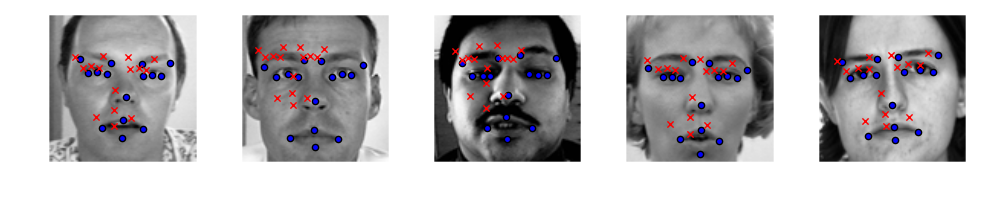

In [19]:
plot_images(5,data =train,result=result,training=False)

In [125]:
#2-layer convnet

mini_batch_size=300
epochs = 40

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

#sess = tf.InteractiveSession()

#Input
x = tf.placeholder(tf.float32, shape=[None, 9216])
y_ = tf.placeholder(tf.float32, shape=[None, 30])

x_image = tf.reshape(x, [-1,96,96,1])#-1 because we don't know the batch size yet.

#
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1) #returns a 48*48 image with 32 filters

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) #returns a 24*24 image with 64 filters

W_fc1 = weight_variable([24 * 24 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])



#sess.run(tf.global_variables_initializer())

y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
#y = tf.matmul(x,W) + b


error = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y_,y))))


train_step = tf.train.AdamOptimizer(1e-4).minimize(error)

#with tf.Session() as sess:
#    sess.run(train_step, feed_dict={x: train_data, y_: train_labels})



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                train_data_instance,train_label_instance,batch_size = next_batch
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+" ="+str(train_accuracy))
        
    
    iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
    next_batch =iter_dev.__next__()
    dev_data_instance,dev_label_instance,batch_size = next_batch
    dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
    dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
    dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
    print ("RMSE for dev set ="+str(dev_accuracy))
    
    

    #Predictions:
    feed_dict = {x: np.stack(train_data), keep_prob: 1.0}
    predictions = y.eval(feed_dict)
    #print predictions
    result =pd.DataFrame(np.stack(np.transpose(predictions),axis=1))

KeyboardInterrupt: 

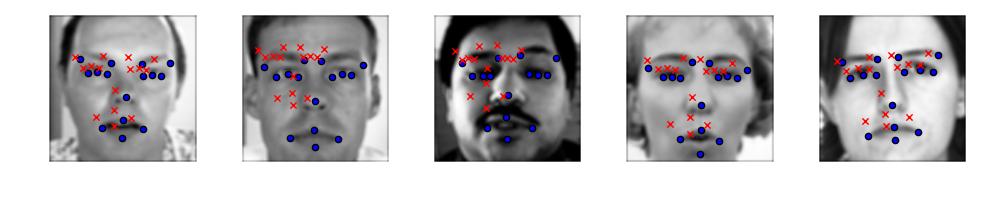

In [30]:
plot_images(5,data =train,result=result,training=False)

In [65]:
#3 convolutional layers and one fully connected layer

mini_batch_size=100
epochs = 50

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

#sess = tf.InteractiveSession()

#Input
x = tf.placeholder(tf.float32, shape=[None, 9216])
y_ = tf.placeholder(tf.float32, shape=[None, 30])

x_image = tf.reshape(x, [-1,96,96,1])#-1 because we don't know the batch size yet.

#
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1) #returns a 48*48 image with 32 filters

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) #returns a 24*24 image with 64 filters

#start
W_conv3 = weight_variable([5, 5, 64, 128])
b_conv3 = bias_variable([128])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3) #returns a 12*12 image with 128 filters

#end

W_fc1 = weight_variable([12 * 12 * 128, 1024])
b_fc1 = bias_variable([1024])

h_pool3_flat = tf.reshape(h_pool3, [-1, 12*12*128])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])



#sess.run(tf.global_variables_initializer())

y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
#y = tf.matmul(x,W) + b


error = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y_,y))))


train_step = tf.train.AdamOptimizer(1e-4).minimize(error)

#with tf.Session() as sess:
#    sess.run(train_step, feed_dict={x: train_data, y_: train_labels})

epoch=[i for i in range(epochs)]
train_error = []
dev_error = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                train_data_instance,train_label_instance,batch_size = next_batch
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
    
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    result =make_predictions(train_data, mini_batch_size-1)
    result_dev =make_predictions(dev_data, mini_batch_size-1)

RMSE for Epoch 0 =14.7596
RMSE for dev set =13.1803
RMSE for Epoch 1 =8.40255
RMSE for dev set =8.53995
RMSE for Epoch 2 =7.34315
RMSE for dev set =8.87254
RMSE for Epoch 3 =5.39012
RMSE for dev set =6.05353
RMSE for Epoch 4 =6.08203
RMSE for dev set =6.76072
RMSE for Epoch 5 =4.88535
RMSE for dev set =6.48792
RMSE for Epoch 6 =5.32439
RMSE for dev set =7.04662
RMSE for Epoch 7 =3.60996
RMSE for dev set =5.34814
RMSE for Epoch 8 =5.00064
RMSE for dev set =5.99152
RMSE for Epoch 9 =3.5827
RMSE for dev set =4.74141
RMSE for Epoch 10 =3.83518
RMSE for dev set =5.30754
RMSE for Epoch 11 =3.46439
RMSE for dev set =5.95766
RMSE for Epoch 12 =3.21071
RMSE for dev set =4.96023
RMSE for Epoch 13 =3.89828
RMSE for dev set =5.06331
RMSE for Epoch 14 =3.79676
RMSE for dev set =5.15066
RMSE for Epoch 15 =3.05324
RMSE for dev set =4.69604
RMSE for Epoch 16 =2.81017
RMSE for dev set =4.641
RMSE for Epoch 17 =4.06605
RMSE for dev set =3.7684
RMSE for Epoch 18 =3.71913
RMSE for dev set =5.92568
RMSE fo

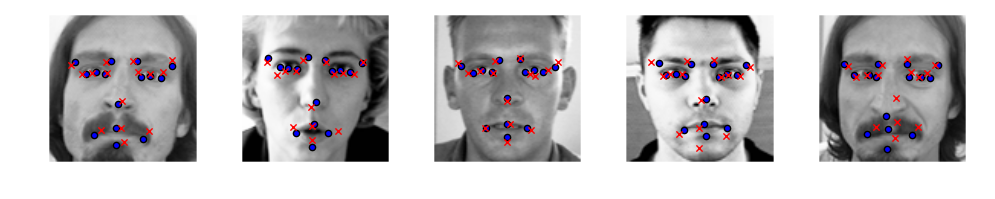

In [66]:
plot_images(5,data =train,result=result,training=False)

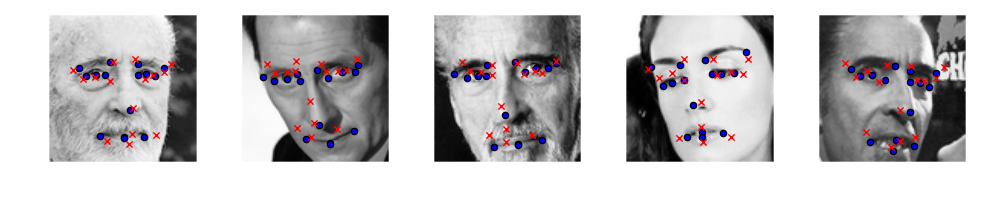

In [67]:
plot_images(5,data =dev,result=result_dev,training=False)

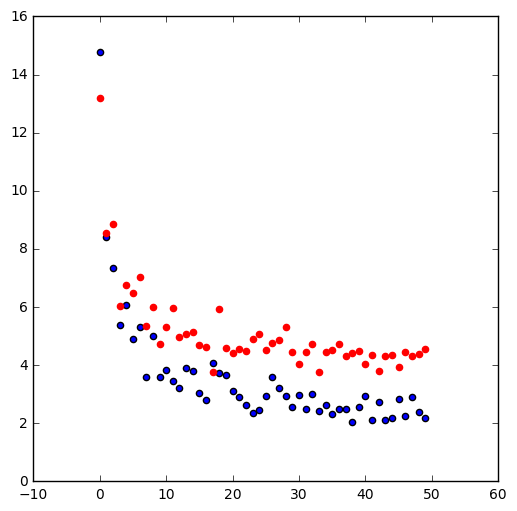

In [68]:
plt.figure(figsize=(6,6))
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")



In [9]:
#4 convolutional layers and one fully connected layer

mini_batch_size=100
epochs = 400

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

#sess = tf.InteractiveSession()

#Input
x = tf.placeholder(tf.float32, shape=[None, 9216])
y_ = tf.placeholder(tf.float32, shape=[None, 30])

x_image = tf.reshape(x, [-1,96,96,1])#-1 because we don't know the batch size yet.

#
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1) #returns a 48*48 image with 32 filters

W_conv2 = weight_variable([3, 3, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) #returns a 24*24 image with 64 filters

#start
W_conv3 = weight_variable([3, 3, 64, 128])
b_conv3 = bias_variable([128])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3) #returns a 12*12 image with 128 filters

#end

#start
W_conv4 = weight_variable([3, 3, 128, 256])
b_conv4 = bias_variable([256])

h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
h_pool4 = max_pool_2x2(h_conv4) #returns a 6*6 image with 256 filters

#end

W_fc1 = weight_variable([6 * 6 * 256, 1024])
b_fc1 = bias_variable([1024])

h_pool4_flat = tf.reshape(h_pool4, [-1, 6*6*256])
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])



#sess.run(tf.global_variables_initializer())

y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
#y = tf.matmul(x,W) + b


error = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y_,y))))


train_step = tf.train.AdamOptimizer(1e-3).minimize(error)

#with tf.Session() as sess:
#    sess.run(train_step, feed_dict={x: train_data, y_: train_labels})

epoch=[i for i in range(epochs)]
train_error = []
dev_error = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                train_data_instance,train_label_instance,batch_size = next_batch
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
    
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    #Predictions:
    result =make_predictions(train_data, mini_batch_size-1)
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)

RMSE for Epoch 0 =4.0759
RMSE for dev set =4.70903
RMSE for Epoch 1 =4.45786
RMSE for dev set =4.80592
RMSE for Epoch 2 =3.86222
RMSE for dev set =4.41069
RMSE for Epoch 3 =2.69152
RMSE for dev set =4.49494
RMSE for Epoch 4 =2.55098
RMSE for dev set =4.35076
RMSE for Epoch 5 =3.07195
RMSE for dev set =4.4258
RMSE for Epoch 6 =3.2258
RMSE for dev set =4.8999
RMSE for Epoch 7 =2.90276
RMSE for dev set =4.57219
RMSE for Epoch 8 =3.76028
RMSE for dev set =4.62071
RMSE for Epoch 9 =3.46419
RMSE for dev set =4.57074
RMSE for Epoch 10 =3.12723
RMSE for dev set =5.56925
RMSE for Epoch 11 =3.47933
RMSE for dev set =4.93773
RMSE for Epoch 12 =3.54541
RMSE for dev set =5.76154
RMSE for Epoch 13 =3.05078
RMSE for dev set =4.53977
RMSE for Epoch 14 =2.35626
RMSE for dev set =4.40644
RMSE for Epoch 15 =2.92243
RMSE for dev set =4.13576
RMSE for Epoch 16 =2.92508
RMSE for dev set =4.20467
RMSE for Epoch 17 =3.18548
RMSE for dev set =4.3404
RMSE for Epoch 18 =2.25131
RMSE for dev set =3.95096
RMSE for

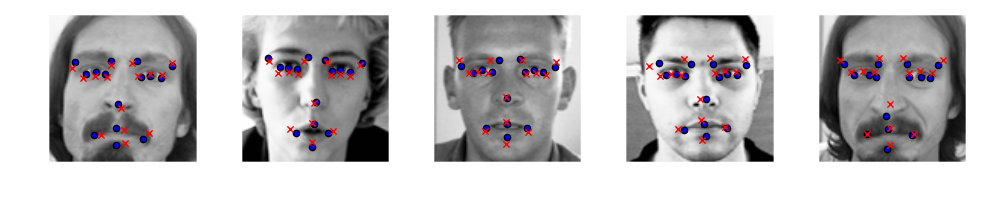

In [10]:
plot_images(5,data =train,result=result,training=False)

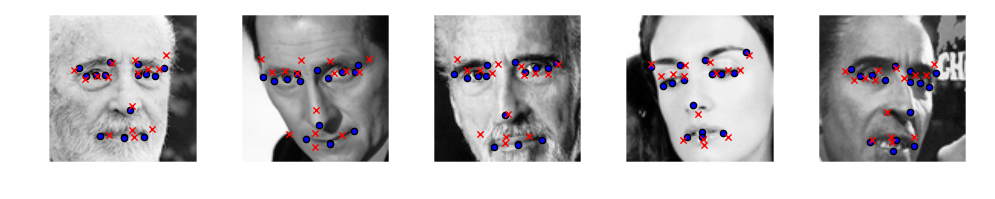

In [11]:
plot_images(5,data =dev,result=result_dev,training=False)

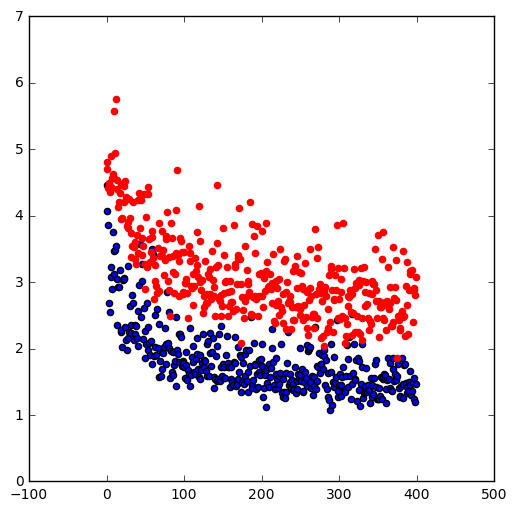

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


In [43]:
'''#flips images horizontally
def flip_images(inputdata):
    data=inputdata.copy()
    data["Image"] = data["Image"].apply(lambda x: np.fliplr(x.reshape((96,96))).flatten())
    for col in data.columns.get_level_values(0)[0:30:2]:
        data[col]=data[col].apply(lambda x: np.max(0,96-x))
    return data'''

def blur_images(inputdata):
    data=inputdata.copy()
    data["Image"] = data["Image"].apply(lambda x: (scipy.signal.convolve2d(x.reshape((96,96)),np.ones((3,3)), mode='same',boundary="fill")/9.0).ravel() )
    return data

def move_images(inputdata,pixels,orientation):
    #pixels= 5 
    #orientation = 'right'
    data = train.copy()
    (dimx,dimy) = (96,96)
    if orientation == 'right':
        padding = np.zeros((dimx,pixels))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
                
        data["Image"] = data["Image"].apply(lambda x: np.hstack((padding,x.reshape(96,96)))[:,0:96])
    
        for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: min(96,x+pixels))
    elif orientation == 'left':
        padding = np.zeros((dimx,pixels))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
        data["Image"] = data["Image"].apply(lambda x: np.hstack((x.reshape(96,96),padding))[:,pixels:96+pixels])
    
        for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: max(0,x-pixels))
    elif orientation == 'up':
        padding = np.zeros((pixels,dimy))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
                
        data["Image"] = data["Image"].apply(lambda x: np.vstack((x.reshape(96,96),padding))[pixels:96+pixels,:])
    
        for col in data.columns.get_level_values(0)[1:30:2]:
            data[col]=data[col].apply(lambda x: max(0,x-pixels))
    elif orientation == 'down':
        padding = np.zeros((pixels,dimy))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
                
        data["Image"] = data["Image"].apply(lambda x: np.vstack((padding,x.reshape(96,96)))[0:96,:])
    
        for col in data.columns.get_level_values(0)[1:30:2]:
            data[col]=data[col].apply(lambda x: min(96,x+pixels))
    
    data["Image"] = data["Image"].apply(lambda x:x.flatten())
    
    return data
    
    

    


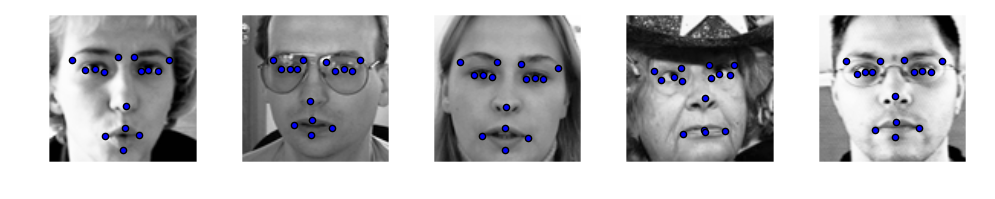

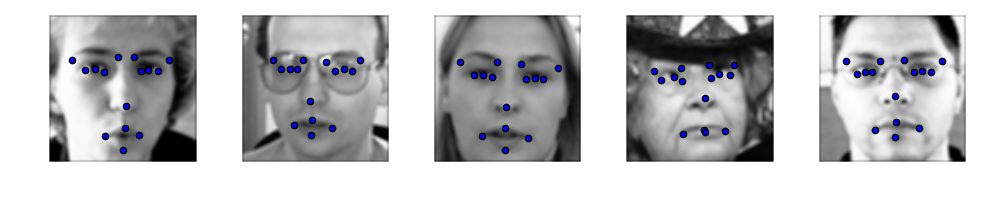

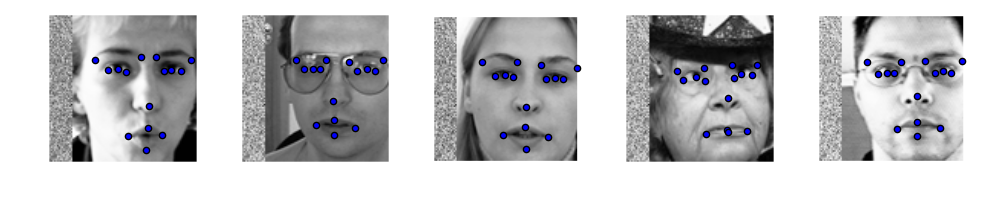

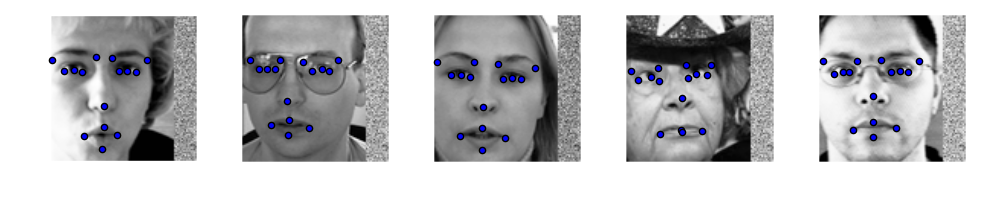

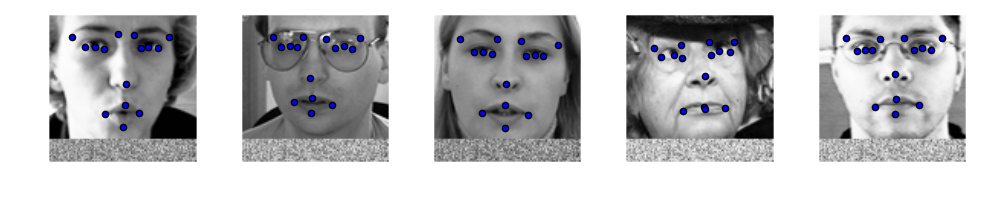

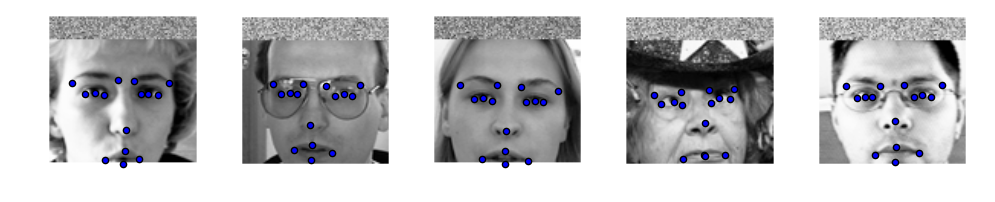

In [44]:
plot_images(5,train)
#plot_images(5,flip_images(train))
plot_images(5,blur_images(train))

plot_images(5,move_images(train,15,"right"))
plot_images(5,move_images(train,15,"left"))
plot_images(5,move_images(train,15,"up"))
plot_images(5,move_images(train,15,"down"))

In [96]:
#Loading the test and raw training datasets
raw = pd.read_csv('/home/ubuntu/FacialKeypoints/data/training.csv')
test = pd.read_csv('/home/ubuntu/FacialKeypoints/data/test.csv')

#Converting image data into numpy arrays and scaling the images
raw["Image"] = raw["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)
test["Image"] = test["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)


raw.dropna(inplace=True)
test.dropna(inplace=True)
raw = raw.sample(frac=1)
raw.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


train_size = 1800
train = raw.iloc[0:train_size,:]
dev = raw.iloc[train_size:raw.shape[0],:]
train.reset_index(inplace=True,drop=True)
dev.reset_index(inplace=True,drop=True)

In [97]:

train = pd.concat([train,blur_images(train)],axis=0)

#,move_images(train,15,"right"),move_images(train,15,"left")
                  #,move_images(train,15,"up"),move_images(train,15,"down")

train.reset_index(inplace=True,drop=True)

In [98]:
#prepping test data using transformations
train_data = train["Image"].as_matrix()
train_labels = np.asarray(train[train.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)


dev_data = dev["Image"].as_matrix()
dev_labels = np.asarray(dev[dev.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)


test_data = test["Image"].as_matrix()

In [99]:
print (train_data.shape)
print (train.shape)
print (dev_data.shape)
print (dev.shape)

(3600,)
(3600, 31)
(340,)
(340, 31)


In [106]:
#4 convolutional layers and one fully connected layer

mini_batch_size=300
epochs = 25

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

#sess = tf.InteractiveSession()

#Input
x = tf.placeholder(tf.float32, shape=[None, 9216])
y_ = tf.placeholder(tf.float32, shape=[None, 30])

x_image = tf.reshape(x, [-1,96,96,1])#-1 because we don't know the batch size yet.

#
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1) #returns a 48*48 image with 32 filters

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) #returns a 24*24 image with 64 filters





W_fc1 = weight_variable([24 * 24 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)


W_fc3 = weight_variable([1024, 30])
b_fc3 = bias_variable([30])



#sess.run(tf.global_variables_initializer())

y = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
#y = tf.matmul(x,W) + b


error = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y_,y))))


train_step = tf.train.AdamOptimizer(1e-2).minimize(error)

#with tf.Session() as sess:
#    sess.run(train_step, feed_dict={x: train_data, y_: train_labels})

epoch=[i for i in range(epochs)]
train_error = []
dev_error = []

config = tf.ConfigProto()
config.gpu_options.allow_growth=True


with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                train_data_instance,train_label_instance,batch_size = next_batch
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
    
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    #Predictions:
    result =make_predictions(train_data, mini_batch_size-1)
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    
    sess.close()

RMSE for Epoch 0 =31.6999
RMSE for dev set =24.857
RMSE for Epoch 1 =13.6905
RMSE for dev set =8.64202
RMSE for Epoch 2 =5.95022
RMSE for dev set =6.04596
RMSE for Epoch 3 =4.58417
RMSE for dev set =9.82253
RMSE for Epoch 4 =3.37598
RMSE for dev set =3.55928
RMSE for Epoch 5 =6.88723
RMSE for dev set =5.75224
RMSE for Epoch 6 =3.50629
RMSE for dev set =2.60688
RMSE for Epoch 7 =3.18512
RMSE for dev set =3.22274
RMSE for Epoch 8 =2.85516
RMSE for dev set =4.04957
RMSE for Epoch 9 =3.57396
RMSE for dev set =2.81798
RMSE for Epoch 10 =4.07719
RMSE for dev set =3.17401
RMSE for Epoch 11 =3.23324
RMSE for dev set =4.38829
RMSE for Epoch 12 =3.23072
RMSE for dev set =3.14295
RMSE for Epoch 13 =3.54426
RMSE for dev set =3.64016
RMSE for Epoch 14 =3.60077
RMSE for dev set =3.19575
RMSE for Epoch 15 =2.62356
RMSE for dev set =3.40076
RMSE for Epoch 16 =2.55793
RMSE for dev set =4.83366
RMSE for Epoch 17 =3.45486
RMSE for dev set =3.60378
RMSE for Epoch 18 =2.62348
RMSE for dev set =2.99097
RMSE

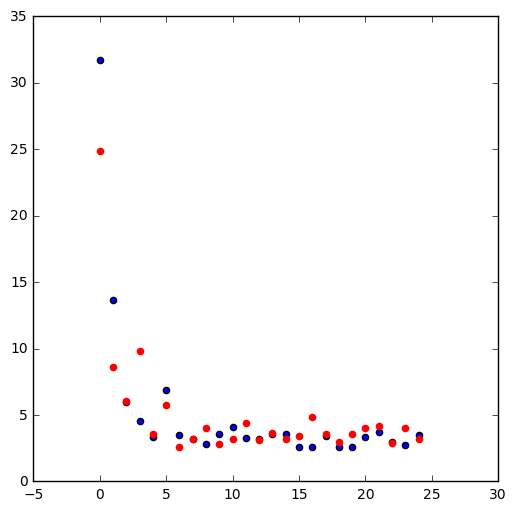

In [107]:
plt.figure(figsize=(6,6))
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


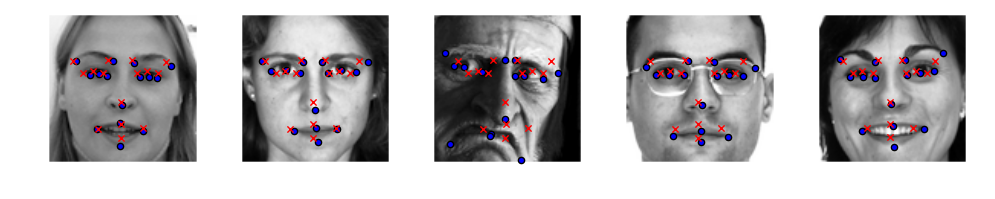

In [108]:
plot_images(5,dev,result_dev,False) 

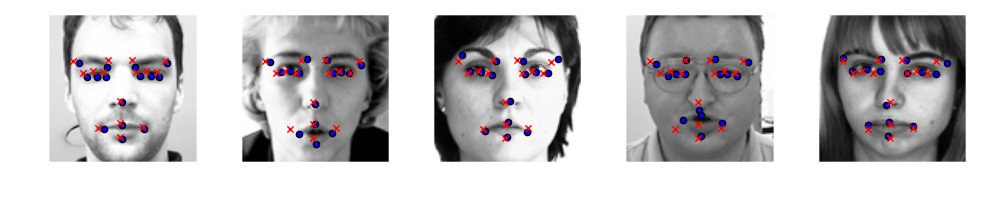

In [109]:
plot_images(5,train,result,False)

In [95]:
generate_results(result_test)